In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

N = 20
ts = pd.Series(
    np.arange(N),
    index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),
    dtype=pd.Int8Dtype,
)

# Lag features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),    
})

# Multistep targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.head(10).style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender'})

In [3]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=16, titlepad=10)
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25")
%config InlineBackend.figure_format = 'retina'

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


data_dir = Path("/content/drive/MyDrive/kaggle/Time_Series/dataset")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

In [4]:
flu_trends.head()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120


In [6]:
flu_trends.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 366 entries, 2009-06-29/2009-07-05 to 2016-06-27/2016-07-03
Freq: W-SUN
Columns: 130 entries, AInfluenza to FluVisits
dtypes: int64(130)
memory usage: 374.6 KB


In [7]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {f'y_lag_{i}': ts.shift(i) for i in range(lead_time, lags + lead_time)}, axis=1)


# Four weeks of lag features
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags=4).fillna(0.0)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [8]:
X.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0


In [9]:
y.head()

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2009-06-29/2009-07-05,180,115.0,132.0,109.0,120.0,115.0,123.0,205.0
2009-07-06/2009-07-12,115,132.0,109.0,120.0,115.0,123.0,205.0,454.0
2009-07-13/2009-07-19,132,109.0,120.0,115.0,123.0,205.0,454.0,628.0
2009-07-20/2009-07-26,109,120.0,115.0,123.0,205.0,454.0,628.0,687.0
2009-07-27/2009-08-02,120,115.0,123.0,205.0,454.0,628.0,687.0,821.0


In [10]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 389.12
Test RMSE: 582.33


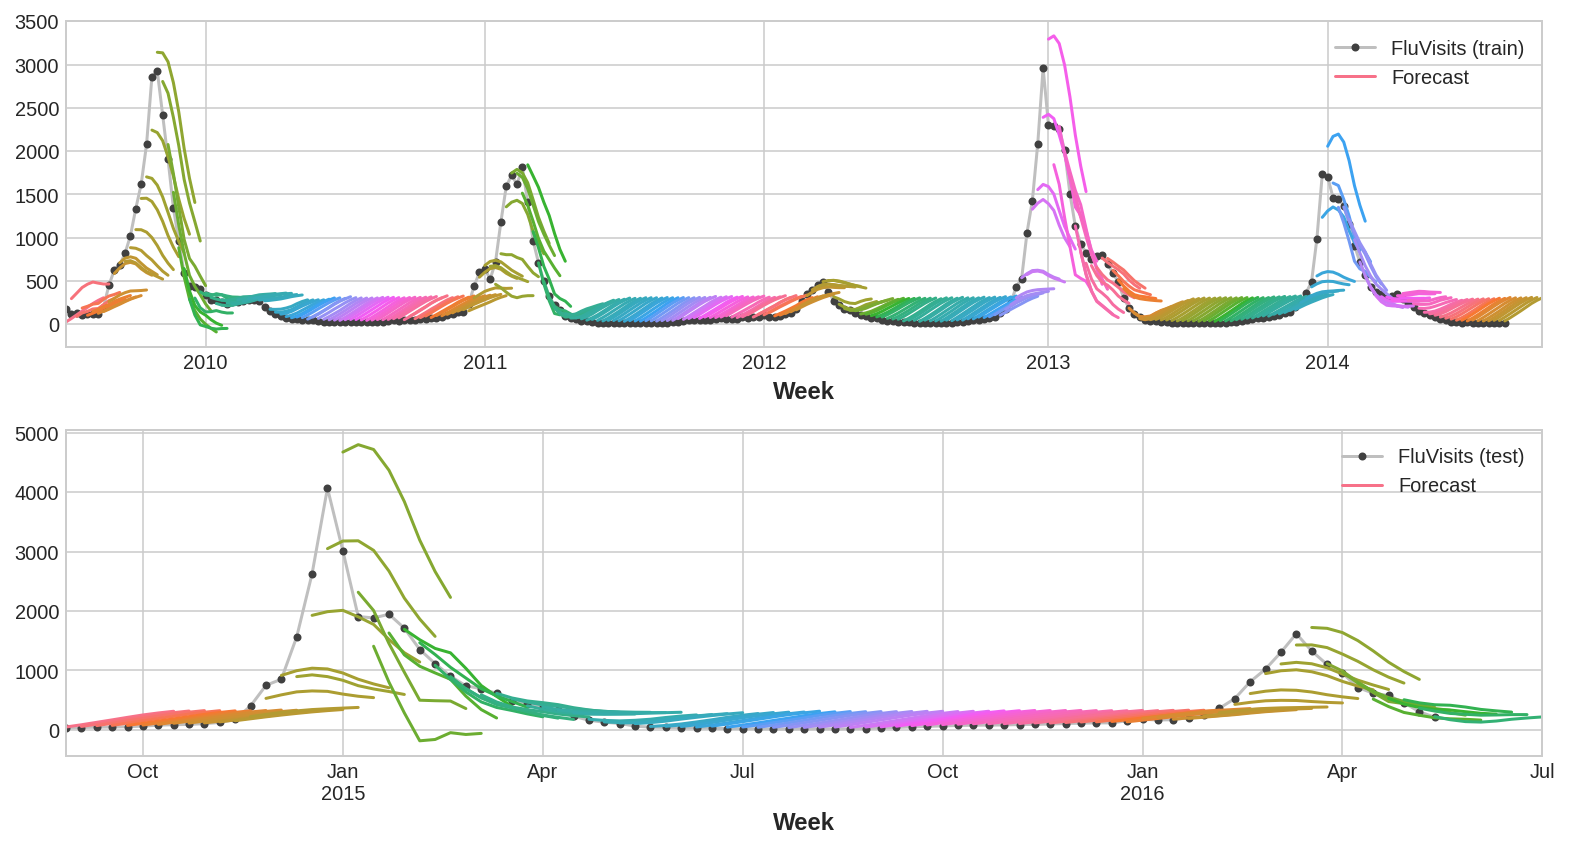

In [11]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

In [12]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 1.22
Test RMSE: 526.45


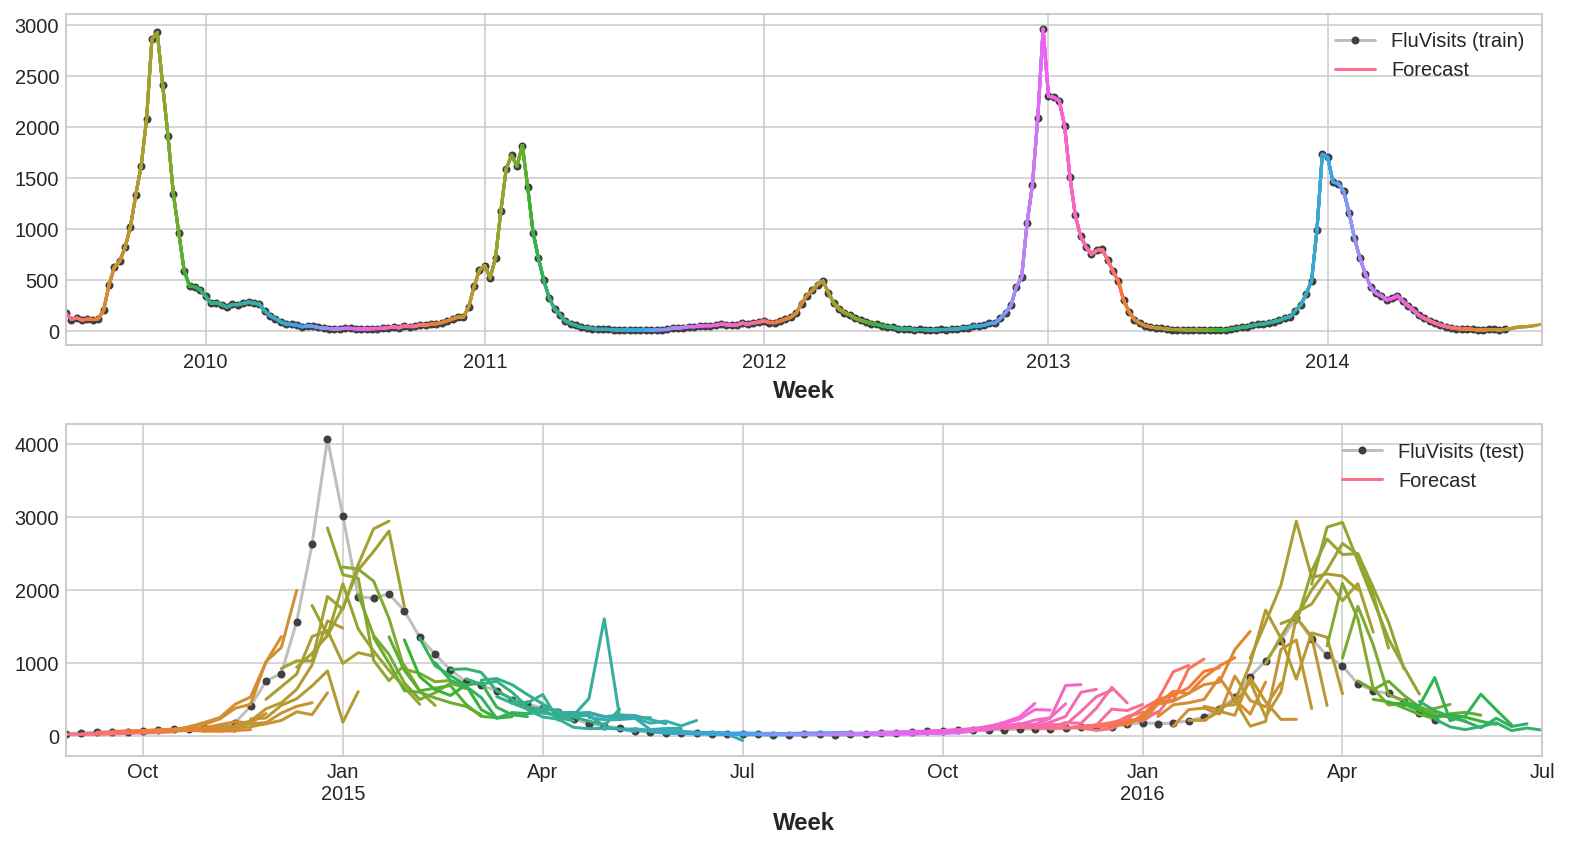

In [13]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])